In [1]:
### TODO:
#   - najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanjuž
#   - dodaj dve opciji globalno prunanje ali prunanje po sloju
#   - izboljšaj early stoppage tako da si shraniš model kot je val večji in ga nato loadaš v primeru če se je učenje prenehalo zaradi early stoppage
#   - v statistiko še dodaj druge metrike kot precision recall in F1
#   - dodaj možnost kjer prunaš samo nekatere uteži npr. samo convolution layerje
#   - popravi napako, kjer se zadnja epoha ne pokaže pre early stoppage

### TODO:
#   - probaj densenet brez pretrained uteži
#   - probaj preprečiti rezanje batch norm plasti v densenet
#   - poglej kaki bodo rezultati če znižaš resolucijo slik
#   - probaj znižati learning rate na 1e-5

#POMEMBNO: Za errror pri squeezenet1_1 je kriva glorotova inicializacija uteži

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from dataset_realwaste import *
from iterative_pruning import IterativePruning

#from torchvision.models import squeezenet1_1
from torchvision.models import densenet121

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 10
BATCH_SIZE = 4
NUM_EPOCHS = 100
IMAGE_SIZE = [224, 224]
#LR = 1.2e-3
LR = 1e-4

In [4]:
## MNIST

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

#X_train = train_subset.dataset.data[train_subset.indices]
#y_train = train_subset.dataset.targets[train_subset.indices]

#X_val = val_subset.dataset.data[val_subset.indices]
#y_val = val_subset.dataset.targets[val_subset.indices]

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
## REALWASTE
inputs, targets, label_encoder = getRealWasteDataset()
real_waste_dataset = RealWasteDataset(inputs, targets)

train_size = int(0.7 * len(real_waste_dataset))
val_size = int(0.15 * len(real_waste_dataset))
test_size = len(real_waste_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(real_waste_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)


Velikost učne množice:   3320
Velikost validacijske množice:   711
Velikost testne množice:   712
Dimenzija slik: (3, 524, 524)
['Paper' 'Textile Trash' 'Vegetation' 'Glass' 'Miscellaneous Trash'
 'Miscellaneous Trash' 'Plastic' 'Cardboard' 'Metal' 'Miscellaneous Trash'
 'Metal' 'Plastic' 'Plastic' 'Vegetation' 'Glass' 'Plastic']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: index 16 is out of bounds for dimension 0 with size 16

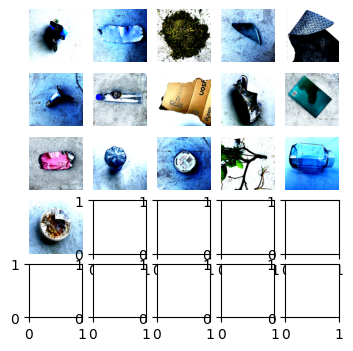

In [5]:
input, targets = next(iter(train_loader))

print(f"Velikost učne množice:   {len(train_dataset)}")
print(f"Velikost validacijske množice:   {len(val_dataset)}")
print(f"Velikost testne množice:   {len(test_dataset)}")
print(f"Dimenzija slik: {input[0].numpy().shape}")

string_decoded = label_encoder.inverse_transform(targets.ravel())
print(string_decoded)

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(input[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [5]:
#model = LeNet300(NUM_CHANNELS)
model = densenet121(weights="IMAGENET1K_V1")
#model = densenet121(weights=None)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

## KANALI SO NA RGB
print(torchinfo.summary(model, (BATCH_SIZE, 3, 524, 524)))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [4, 1000]                 --
├─Sequential: 1-1                        [4, 1024, 16, 16]         --
│    └─Conv2d: 2-1                       [4, 64, 262, 262]         9,408
│    └─BatchNorm2d: 2-2                  [4, 64, 262, 262]         128
│    └─ReLU: 2-3                         [4, 64, 262, 262]         --
│    └─MaxPool2d: 2-4                    [4, 64, 131, 131]         --
│    └─_DenseBlock: 2-5                  [4, 256, 131, 131]        --
│    │    └─_DenseLayer: 3-1             [4, 32, 131, 131]         45,440
│    │    └─_DenseLayer: 3-2             [4, 32, 131, 131]         49,600
│    │    └─_DenseLayer: 3-3             [4, 32, 131, 131]         53,760
│    │    └─_DenseLayer: 3-4             [4, 32, 131, 131]         57,920
│    │    └─_DenseLayer: 3-5             [4, 32, 131, 131]         62,080
│    │    └─_DenseLayer: 3-6             [4, 32, 131, 131]   

In [6]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name and "norm" not in name:
        print(name)
        print(np.shape(param.data))

features.conv0.weight
torch.Size([64, 3, 7, 7])
features.denseblock1.denselayer1.conv1.weight
torch.Size([128, 64, 1, 1])
features.denseblock1.denselayer1.conv2.weight
torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer2.conv1.weight
torch.Size([128, 96, 1, 1])
features.denseblock1.denselayer2.conv2.weight
torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer3.conv1.weight
torch.Size([128, 128, 1, 1])
features.denseblock1.denselayer3.conv2.weight
torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer4.conv1.weight
torch.Size([128, 160, 1, 1])
features.denseblock1.denselayer4.conv2.weight
torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer5.conv1.weight
torch.Size([128, 192, 1, 1])
features.denseblock1.denselayer5.conv2.weight
torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer6.conv1.weight
torch.Size([128, 224, 1, 1])
features.denseblock1.denselayer6.conv2.weight
torch.Size([32, 128, 3, 3])
features.transition1.conv.weight
torch.Size([128, 256, 1, 1]

In [7]:
ip = IterativePruning(model)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, 2, 0, 0.2)

 ===| Prune iteration 1/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
all                                   0  7936032  7936032     100.00%


Epoch: 5, loss: 1.0820, val_loss: 1.7217 Validating: : 178it [00:12, 14.36it/s]                       
Testing: 100%|██████████| 178/178 [00:20<00:00,  8.82it/s]


Accuracy: 0.586


 ===| Prune iteration 2/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
all                             1587206  6348826  7936032      80.00%


Epoch: -, loss: -.----, val_loss: -.---- Training:   8%|▊         | 67/830 [00:14<02:50,  4.49it/s]

KeyboardInterrupt: 

In [ ]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))